# <font color='blue'> Machine Learning</font>

# <font color='blue'> Mini-Projeto - Agrupando Clientes Por Consumo de Energia</font>


### Especificação

A partir de dados de consumo de energia de clientes, nosso trabalho é agrupar os consumidores por similaridade a afim de compreender o comportamento dos clientes e sua relação com o consumo de energia.

#### Fonte de Dados
https://archive.ics.uci.edu/ml/datasets/Individual+household+electric+power+consumption

Será realizada as seguintes tarefas:
    
1- Tratar os valores ausentes nos dados.

2- Coletar uma amostra de 1% dos dados para criar o modelo de clusterização com o K-Means.

3- Encontrar o melhor valor de K para esse conjunto de dados.

4- Criar o modelo K-Means usando o valor de K encontrado no item 3.

5- Criar um Meshgrid para visualização de todos os clusters.

6- Visualizar os centróides.

7- Calcular o Silhoutte Score.

8 - Calcular a média de consumo de energia por cluster (usar a coluna Global_active_power para o cálculo da média).

Dica: Para o item 8, considere a amostra criada no item 2.

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pylab
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cdist, pdist
from sklearn.metrics import silhouette_score
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import MeanShift
from sklearn.datasets import make_blobs
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

### Carregando os dados


In [2]:
dataset = pd.read_csv('dados/household_power_consumption.txt', delimiter = ';', low_memory = False)

In [3]:
# Visualização dos dados importados
dataset.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [4]:
# Gerando a quantidade total de linhas do dataset original

dataset.shape

(2075259, 9)

#### Como podemos ver há muitas quantidades de linhas nesse dataset, o ideal nesse caso seria criar um cluster no apache hadoop para trabalhar com todos os dados do dataset.
#### No caso desse mini-projeto será executado um uma máquina normal 1% do Dataset em uma máquina simples para não consumir toda a memória e processamento da máquina.

#### Verificando os tipos dos atributos

In [5]:
dataset.dtypes

Date                      object
Time                      object
Global_active_power       object
Global_reactive_power     object
Voltage                   object
Global_intensity          object
Sub_metering_1            object
Sub_metering_2            object
Sub_metering_3           float64
dtype: object

#### Verificando os valores ausentes

In [6]:
dataset.isnull().sum()

Date                         0
Time                         0
Global_active_power          0
Global_reactive_power        0
Voltage                      0
Global_intensity             0
Sub_metering_1               0
Sub_metering_2               0
Sub_metering_3           25979
dtype: int64

#### Checando se há valores nulos

In [7]:
dataset.isnull().values.any()

True

#### Tratando os valores ausentes nos dados e excluindo as colunas data e hora, pois não será validado nesse mini-projeto, devido querermos apenas a média de consumo generalizada.

In [8]:
dataset = dataset.iloc[0:,2:9].dropna()

#### Em vez de remover os valores ausentes, preferi preenchê-los com valores apropriados. 


In [44]:
#Em vez de remover os valores ausentes,preferi preenchê-los com valores apropriados. 
# Utilizei o método fillna do pandas porque obervei que os dados da coluna Sub_metering_3 seguem como 0.00.
dataset['Sub_metering_3'] = dataset['Sub_metering_3'].fillna(dataset['Sub_metering_3'].mean())

#### Abaixo, podemos observar que não há mais valores ausentes, agora podemos trabalhar com os dados.

In [10]:
dataset.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [11]:
#Obtendo apenas os valores dos atributos

dataset_atrib = dataset.values

In [12]:
dataset_atrib

array([['4.216', '0.418', '234.840', ..., '0.000', '1.000', 17.0],
       ['5.360', '0.436', '233.630', ..., '0.000', '1.000', 16.0],
       ['5.374', '0.498', '233.290', ..., '0.000', '2.000', 17.0],
       ...,
       ['0.938', '0.000', '239.820', ..., '0.000', '0.000', 0.0],
       ['0.934', '0.000', '239.700', ..., '0.000', '0.000', 0.0],
       ['0.932', '0.000', '239.550', ..., '0.000', '0.000', 0.0]],
      dtype=object)

#### Coletando apenas 1% dos dados para criar o modelo de Clusterização como K-Means, para não comprometer a memória do computador

In [13]:
# amostra = int(len(dataset) * 0.01) = forma simples
# forma completa:
amostra1,amostra2 = train_test_split(dataset_atrib,train_size = .01)

In [14]:
# Gerando a quantidade de linhas total da amostra coletada de 1% do total de linhas do dataset original
amostra1.shape

(20492, 7)

#### Será aplicada a redução de dimensionalidade para visar o aceleramento do tempo de desemvolvimento. Ao invés de trabalhar com as 7 variáveis uma por uma, irei trabalhar com 2 componentes apenas, ou seja a mesma informação das 7 variárias estará compactada em 2 componentes. Com isso será utilizado auto valores e auto vetores.


In [15]:
# Aplicando a redução de dimensionalidade
pca = PCA(n_components = 2).fit_transform(amostra1)

In [16]:
#Determinando um range de K
k_range = range (1,12)

#### Aplicando o modelo K-means para cada valor de K (esta célula pode levar bastante tempo pra ser executada)

In [17]:

# "for k in k_range" = para cada valor de k dentro do range de k, então, 
# chamo o algoritmo KMeans e vou passar o k como parâmetro (n_clusters = k), vou fazer o fit no pca e será colocado dentro da lista de modelos = k_means_var

k_means_var = [KMeans(n_clusters = k).fit(pca) for k in k_range] #list comprehension


In [18]:
# Ajustando o centróide do cluster para cada modelo
centroids = [X.cluster_centers_ for X in k_means_var]

#### Calculando a distância euclidiana de cada ponto de dado para o centróide 


In [19]:
#"for cent in centroids" = para cada cenroids na minha lista de centroids eu vou calcular a distancia entre
# o pca (que é a lista de componentes pricipais) para o centroid "cdist(pca, cent, 'euclidean'" utilizando como medida, a distância euclidiana.

k_euclid = [cdist(pca, cent, 'euclidean') for cent in centroids]

# "for ke in k_euclid" = pra cada distancia na minha lista de distâncias, vou pegar o menor valor da lista "np.min" colocar no eixo 1 = axis =1
dist = [np.min(ke,axis=1) for ke in k_euclid]

#### A seguir será calculada 3 métricas

In [20]:
# Soma dos quadrados das distâncias dentro do Cluster
soma_quadrados_intra_cluster = [sum(d**2) for d in dist]

In [21]:
# Soma total dos quadrados
soma_total = sum(pdist(pca)**2)/pca.shape[0]


In [22]:
# Soma total dos quadrados entre clusters
soma_quadrados_inter_cluster = soma_total - soma_quadrados_intra_cluster


In [23]:
# Soma dos quadrados entre clusters
soma_quadrados_inter_cluster = soma_total - soma_quadrados_intra_cluster

#### Curva de ELBOW

#### Explicação da Variância dos Dados, aonde podemo observar que o valor de k a partir de 8 parece ser o ideal a partir desse conjunto de dados.

Text(0, 0.5, 'Percentual de Variância Explicada')

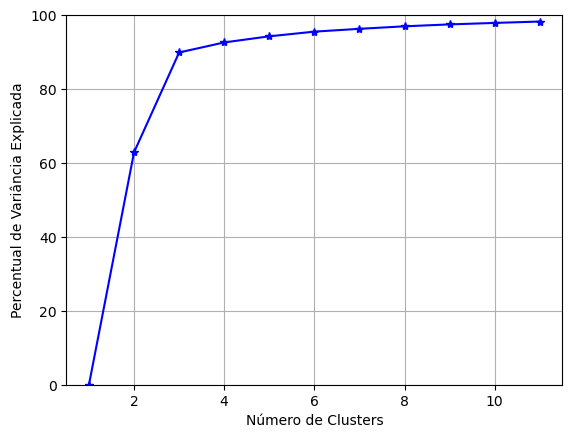

In [24]:
fig= plt.figure()
ax = fig.add_subplot(111)
ax.plot(k_range, soma_quadrados_inter_cluster/soma_total *100, 'b*-')
ax.set_ylim((0,100))
plt.grid(True)
plt.xlabel('Número de Clusters')
plt.ylabel('Percentual de Variância Explicada')


### Criando um Modelo

In [25]:
# Criando um modelo com K = 8
modelo_v1 = KMeans(n_clusters = 8)
modelo_v1.fit(pca)

KMeans()

#### Criando um plot com meshgrid apenas para visualizar as áreas aonde os clusters estão localizados, para verificar os dados através de um gráfico. 

In [26]:
# Obtém os valores mínimos e máximos e organiza o shape
x_min, x_max = pca[:, 0].min() - 5, pca[:, 0].max() - 1
y_min, y_max = pca[:, 1].min() + 1, pca[:, 1].max() + 5
xx, yy = np.meshgrid(np.arange(x_min, x_max, .02), np.arange(y_min, y_max, .02))
Z = modelo_v1.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

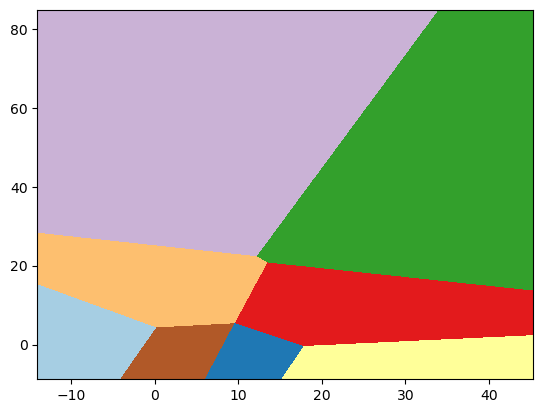

In [27]:
# Plot das áreas dos clusters
plt.figure(1)
plt.clf()
plt.imshow(Z, 
           interpolation = 'nearest',
           extent = (xx.min(), xx.max(), yy.min(), yy.max()),
           cmap = plt.cm.Paired,
           aspect = 'auto', 
           origin = 'lower')

### Criando o gráfico de pontos para plotar os centróids 
#### O gráfico foi dividido em 2 grupos, no grupo da parte inferior do gráfico podemos observar que há uma densidade maior de dados, em relação ao grupo mais acima possue a densidade menor de dados. Sendo assim, a partir daqui ainda não é possível afirmar que o k= 8 é o melhor número, para isso, é preciso calcular uma métrica de clusterização que é o slhouette score.

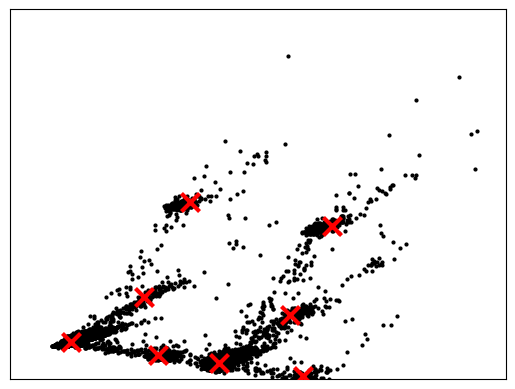

In [29]:
# Plot dos centróides
plt.plot(pca[:, 0], pca[:, 1], 'k.', markersize = 4)
centroids = modelo_v1.cluster_centers_
inert = modelo_v1.inertia_
plt.scatter(centroids[:, 0], centroids[:, 1], marker = 'x', s = 169, linewidths = 3, color = 'r', zorder = 8)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

### Para analisarmos o resultado do silhouette score precisamos considerar a seguinte regra:
#### O melhor valor do score é 1 e o pior valor é -1, valores próximos de zero indicam overlapping de clusters.

In [30]:
?silhouette_score

#### Como podemos observar abaixo foi utilizado no modelo 1 o valor de K = 8, ele parece ser um bom número, pois o resultado do silhouette score é proximo de 1

In [31]:
# Silhouette Score
labels = modelo_v1.labels_
silhouette_score(pca, labels, metric = 'euclidean')

0.8149554080778277

#### A seguir, criaremos o modelo 2 , porém utilizando o valor de k = 10 para analisar o silhouette score:

In [32]:
# Criando um modelo com K = 10
modelo_v2 = KMeans(n_clusters = 10)
modelo_v2.fit(pca)

KMeans(n_clusters=10)

In [33]:
# Obtém os valores mínimos e máximos e organiza o shape
x_min, x_max = pca[:, 0].min() - 5, pca[:, 0].max() - 1
y_min, y_max = pca[:, 1].min() + 1, pca[:, 1].max() + 5
xx, yy = np.meshgrid(np.arange(x_min, x_max, .02), np.arange(y_min, y_max, .02))
Z = modelo_v2.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

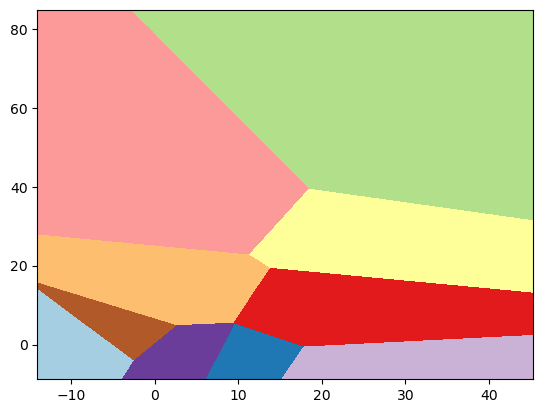

In [34]:
# Plot das áreas dos clusters
plt.figure(1)
plt.clf()
plt.imshow(Z, 
           interpolation = 'nearest',
           extent = (xx.min(), xx.max(), yy.min(), yy.max()),
           cmap = plt.cm.Paired,
           aspect = 'auto', 
           origin = 'lower')

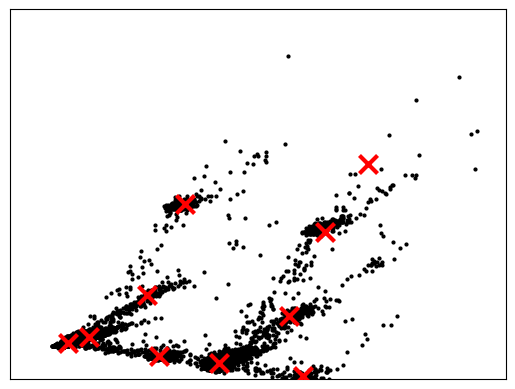

In [35]:
# Plot dos centróides
plt.plot(pca[:, 0], pca[:, 1], 'k.', markersize = 4)
centroids = modelo_v2.cluster_centers_
inert = modelo_v2.inertia_
plt.scatter(centroids[:, 0], centroids[:, 1], marker = 'x', s = 169, linewidths = 3, color = 'r', zorder = 8)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

#### De acordo com o resultado do silhouette score do modelo 2, podemos verificar que ele está mais próximo de zero em relação do do modelo 1. Portanto, analisando esses resultados, é possível definir que o melhor valor de k é 8, utilizado no modelo 1.

In [36]:
# Silhouette Score
labels = modelo_v2.labels_
silhouette_score(pca, labels, metric = 'euclidean')

0.6720463409635128

### Criando o Cluster Map com os clusters do Modelo 1 que apresentou melhor Silhouette Score.

In [38]:
# Lista com nomes das colunas = Criando uma lista com os nomes das colunas, 
# para dar um nome para cada coluna de acordo com o dataseg original e depois usar depois como indexação.
names = ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']

In [43]:
# Cria o cluster map
cluster_map = pd.DataFrame(amostra1, columns = names) # transformando a amostra 1 em um dataframe e danto os nomes as colunas. 
cluster_map['Global_active_power'] = pd.to_numeric(cluster_map['Global_active_power'])#convert para numérico p/ calcular a média.
cluster_map['cluster'] = modelo_v1.labels_ # Criando uma nova coluna com os Clusters

In [40]:
cluster_map

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,cluster
0,1.846,0.212,237.300,7.800,0.000,0.000,18.0,1
1,1.510,0.226,239.350,6.200,1.000,1.000,18.0,1
2,1.282,0.046,240.320,5.200,0.000,0.000,17.0,1
3,0.546,0.224,236.450,2.400,0.000,4.000,0.0,0
4,1.468,0.176,238.510,6.200,0.000,0.000,18.0,1
...,...,...,...,...,...,...,...,...
20487,0.410,0.198,244.470,1.800,0.000,2.000,0.0,0
20488,1.632,0.000,238.870,6.800,0.000,0.000,18.0,1
20489,0.244,0.200,240.330,1.200,0.000,0.000,0.0,0
20490,0.208,0.110,242.280,1.000,0.000,0.000,1.0,0


#### Calculando a média de consumo de energia por cluster

In [41]:
# Calcula a média de consumo de energia por cluster utilizando o group by
cluster_map.groupby('cluster')['Global_active_power'].mean()

cluster
0    0.506391
1    1.816545
2    4.540058
3    3.845205
4    2.698728
5    3.390786
6    2.366889
7    1.090451
Name: Global_active_power, dtype: float64

### Conclusão 
#### Podemos observar que no resultado acima, o grupo/cluster que possue maior média de consumo de energia é o grupo de número 2.


### Fim